In [ ]:
from google.colab import drive

###################
## Configuration ##  
###################

# Google drive folders
drive.mount('/gdrive', force_remount='True')

Mounted at /gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from os import rename, path, makedirs, listdir, getcwd
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from google.colab.patches import cv2_imshow
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

working_dir = '/gdrive/MyDrive/rx_edad_osea/'
images_dir = working_dir + "./all_images/"

# Declaraciones de metodos de ayuda

In [ ]:
#funcion para dejar todas las imagenes del mismo tamaño
def preprocess_image(image_path, image_size):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  if pad_images:
    img = tf.image.resize_with_pad(img, image_size[1], image_size[0]) # img, height, width
  else:
    img = tf.image.resize(img, (image_size[1], image_size[0]))  # img, (height, width)
  return img.numpy()

#generar conjuntos de entrenamiento y test
def split_training_set_and_test_set(images, labels, training_set_count):
  images_arr = np.array(images)
  labels_arr = np.array(labels)
  idx = np.arange(0,len(images_arr))
  np.random.shuffle(idx)

  idx_train=idx[:training_set_count]
  idx_test=idx[training_set_count:]

  train = (images_arr[idx_train], labels_arr[idx_train])
  test = (images_arr[idx_test], labels_arr[idx_test])
  return (train, test)

def plot_predictions(prediction_train, prediction_test, name_postfix = ''):
  title = model_name + '_' + name_postfix
  fig= plt.figure()
  plt.scatter(train_labels,prediction_train)
  plt.scatter(test_labels,prediction_test)
  plt.plot((0,200),(0,200))
  plt.title(title)
  plt.savefig(models_dir + '/' + model_name + '/' + name_postfix + '.png')

def save_statistics(name_postfix = ''):
  prediction_train = model.predict(train_set)
  prediction_test = model.predict(test_set)
  folder = models_dir + '/' + model_name + '/'
  model.save(folder + 'model_' + name_postfix + '.h5')
  plot_predictions(prediction_train, prediction_test, name_postfix)
  train_csv = np.c_[train_labels, prediction_train]
  test_csv = np.c_[test_labels, prediction_test]
  np.savetxt(folder + 'predictions_test_' + name_postfix + '.csv', train_csv, delimiter=';', fmt='%s')
  np.savetxt(folder + 'predictions_train_' + name_postfix + '.csv', test_csv, delimiter=';', fmt='%s')
  keras.utils.plot_model(model, to_file=folder+'model.png', show_shapes=True)

def plot_training_history(history, name_postfix = ''):
  title = model_name + '_' + name_postfix
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  plt.title(title)

  ax1.plot(history.history['mean_absolute_error'])
  ax1.plot(history.history['val_mean_absolute_error'])
  ax1.set_title('Model MAE')
  ax1.set_ylabel('mae')
  ax1.set_xlabel('epoch')
  ax1.legend(['train','validation'], loc='upper left')

  ax2.plot(history.history['mean_absolute_percentage_error'])
  ax2.plot(history.history['val_mean_absolute_percentage_error'])
  ax2.set_title('Model MAPE')
  ax2.set_ylabel('mape')
  ax2.set_xlabel('epoch')
  ax2.legend(['train','validation'], loc='upper left')

  ax3.plot(history.history['loss'])
  ax3.plot(history.history['val_loss'])
  ax3.set_title('Model Loss')
  ax3.set_ylabel('loss')
  ax3.set_xlabel('epoch')
  ax3.legend(['train','validation'], loc='upper left')

  fig.set_figwidth(val=30)
  fig.savefig(models_dir + '/' + model_name + '/history_' + name_postfix + '.png')

# ----------------------------------------------------------------------
# plot de mapeo tsne/pca u otros segun etiqueta
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min) #normalizar los datos

    plt.figure(figsize=(15,15))
    ax = plt.subplot(111)
    min = np.min(y)
    max = np.max(y)
    norm = mpl.colors.Normalize(vmin=min, vmax=max)
    cmap  = plt.cm.Set1
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in range(X.shape[0]):
      color = m.to_rgba(y[i]) #plt.cm.Set1(y[i] / 10.)
      
      plt.text(X[i, 0], X[i, 1], str(y[i]),
               color=color,
               fontdict={'weight': 'bold', 'size': 10})

    
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

# Preparacion de los datos

In [ ]:
pad_images = True
initialize_images = True # Set this to true the first time you open this because the images are not in RAM (or if you change some setting)
input_size = (224, 224) # recomended sizes: 96, 128, 160, 192, 224
# Input saving
save_initialized_images_to_disk = False # Only used if initialize_images = True
input_dir = working_dir + "./input_data/" # If save_initialized_images_to_disk = true, where the output np arrays should be saved? 
models_dir = working_dir + "./models/" # Model results will be saved in models_dir + "/" + model_name

if initialize_images:
  images = []
  labels = []
  all_image_paths = listdir(images_dir)
  i = 0
  for (file_name) in all_image_paths:
      i += 1
      image_path = path.join(images_dir, file_name)
      label_str = file_name.split('-')[0]
      if not file_name.startswith('.') and path.isfile(image_path) and label_str.isdigit():
          progress = i / len(all_image_paths) * 100
          print(f'\rProgreso: {progress:.2f}%', end='')
          images.append(preprocess_image(image_path, input_size))
          labels.append(int(label_str))

Progreso: 100.00%

## Creación de modelo

In [ ]:
# Create a base model and freeze it
base_model = keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(input_size[1],input_size[0], 3)
)

inputs = keras.Input(shape=(input_size[1],input_size[0], 3))  # height, width, channels
x = base_model(inputs, training=False)
output = keras.layers.GlobalAveragePooling2D()(x)
model = keras.models.Model(inputs,output)


9420800/9406464 [==============================] - 0s 0us/step


## Predicción

In [ ]:
tabla_mn = model.predict(np.array(images))
print(tabla_mn.shape)
print(np.array(images).shape)

## Mapeo t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


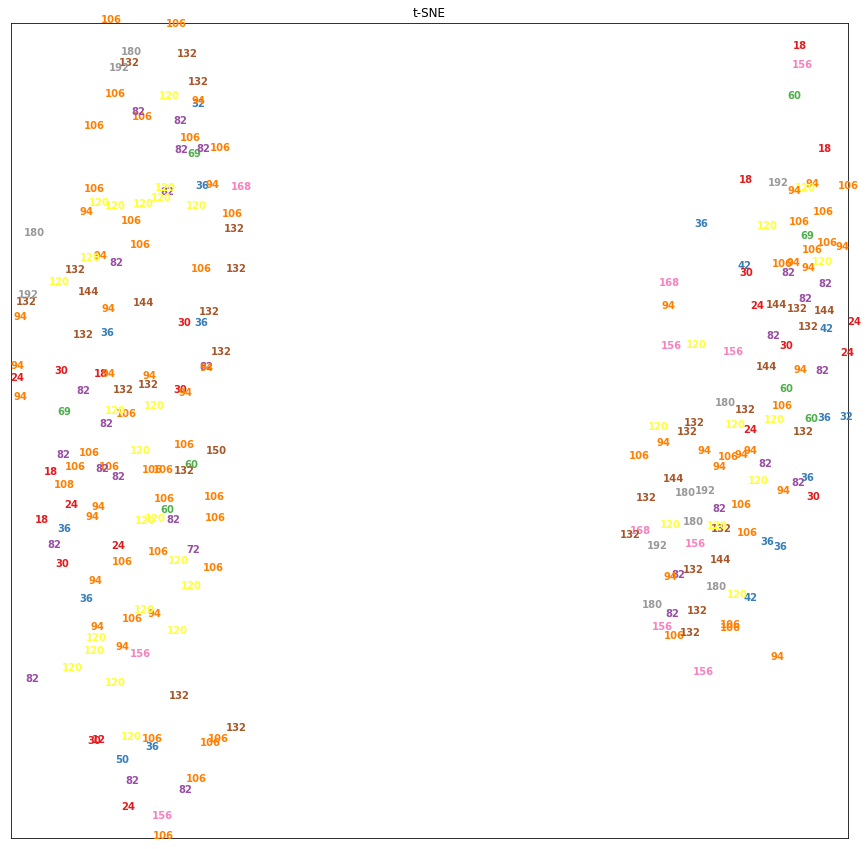

In [ ]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(tabla_mn)

plot_embedding(X_tsne,labels,"t-SNE")

In [ ]:
print(np.min(labels))
print(np.max(labels))
print(len(plt.cm.Set1.colors))


12
192
9


(247, 7, 7, 1280)
(247, 224, 224, 3)